In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

%matplotlib inline
plt.style.use(['dark_background'])
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

In [2]:
# 데이터 불러오기
train = pd.read_csv('train_preprocessed_10.20.csv')
test = pd.read_csv('test_preprocessed_10.20.csv')

In [12]:
train

,Unnamed: 0,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BUILT,LENGTH,SHIPMANAGER,FLAG,ATA_LT,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday,holiday,sin_time_hour,cos_time_hour,sin_time_month,cos_time_month,sin_time_weekday,cos_time_weekday,sin_time_minute,cos_time_minute
0,0,SG,GIW5,Container,30.881018,Z618338,24,180.0,CQSB78,Panama,5,0.002615,3.450000,2018,12,17,21,29,0,1,-0.707107,7.071068e-01,-2.449294e-16,1.000000e+00,0.000000,1.000000,1.045285e-01,-9.945219e-01
1,1,IN,UJM2,Bulk,0.000000,X886125,13,180.0,SPNO34,Marshall Islands,12,0.000217,0.000000,2014,9,23,6,59,1,1,1.000000,6.123234e-17,-1.000000e+00,-1.836970e-16,0.781831,0.623490,-1.045285e-01,9.945219e-01
2,2,CN,EUC8,Container,0.000000,T674582,12,370.0,FNPK22,Malta,6,0.001614,0.000000,2015,2,3,22,0,1,0,-0.500000,8.660254e-01,8.660254e-01,5.000000e-01,0.781831,0.623490,0.000000e+00,1.000000e+00
3,3,JP,ZAG4,Container,0.000000,Y847238,18,120.0,PBZV77,Bahamas,13,0.000356,0.000000,2020,1,17,4,2,4,1,0.866025,5.000000e-01,5.000000e-01,8.660254e-01,-0.433884,-0.900969,2.079117e-01,9.781476e-01
4,4,SG,GIW5,Container,27.037650,A872328,10,300.0,GUCE76,Liberia,15,0.002615,253.554444,2020,1,26,7,51,6,1,0.965926,-2.588190e-01,5.000000e-01,8.660254e-01,-0.781831,0.623490,-8.090170e-01,5.877853e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379812,379812,JP,QYY1,Container,0.000000,Y375615,27,110.0,KEJZ24,"China, People's Republic Of",14,0.000552,0.000000,2017,6,6,5,2,1,1,0.965926,2.588190e-01,1.224647e-16,-1.000000e+00,0.781831,0.623490,2.079117e-01,9.781476e-01
379813,379813,SG,GIW5,Bulk,5.884603,K635567,12,80.0,JLTM64,Vietnam,8,0.002615,144.061389,2019,10,16,0,36,2,1,0.000000,1.000000e+00,-8.660254e-01,5.000000e-01,0.974928,-0.222521,-5.877853e-01,-8.090170e-01
379814,379814,US,QGN3,Bulk,70.660241,J284147,8,200.0,YERJ68,Singapore,18,0.000155,41.482222,2021,3,23,22,35,1,1,-0.500000,8.660254e-01,1.000000e+00,6.123234e-17,0.781831,0.623490,-5.000000e-01,-8.660254e-01
379815,379815,TW,JWI3,Container,9.448179,J644215,29,170.0,HCZK58,Comoros,15,0.000990,7.485278,2015,1,8,7,15,3,1,0.965926,-2.588190e-01,5.000000e-01,8.660254e-01,0.433884,-0.900969,1.000000e+00,2.832769e-16


In [3]:
train = train.drop(columns='Unnamed: 0')
test = test.drop(columns='Unnamed: 0')

In [5]:
train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BUILT,LENGTH,SHIPMANAGER,FLAG,ATA_LT,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday,holiday,sin_time_hour,cos_time_hour,sin_time_month,cos_time_month,sin_time_weekday,cos_time_weekday,sin_time_minute,cos_time_minute
0,SG,GIW5,Container,30.881018,Z618338,24,180.0,CQSB78,Panama,5,0.002615,3.450000,2018,12,17,21,29,0,1,-0.707107,7.071068e-01,-2.449294e-16,1.000000e+00,0.000000,1.000000,1.045285e-01,-9.945219e-01
1,IN,UJM2,Bulk,0.000000,X886125,13,180.0,SPNO34,Marshall Islands,12,0.000217,0.000000,2014,9,23,6,59,1,1,1.000000,6.123234e-17,-1.000000e+00,-1.836970e-16,0.781831,0.623490,-1.045285e-01,9.945219e-01
2,CN,EUC8,Container,0.000000,T674582,12,370.0,FNPK22,Malta,6,0.001614,0.000000,2015,2,3,22,0,1,0,-0.500000,8.660254e-01,8.660254e-01,5.000000e-01,0.781831,0.623490,0.000000e+00,1.000000e+00
3,JP,ZAG4,Container,0.000000,Y847238,18,120.0,PBZV77,Bahamas,13,0.000356,0.000000,2020,1,17,4,2,4,1,0.866025,5.000000e-01,5.000000e-01,8.660254e-01,-0.433884,-0.900969,2.079117e-01,9.781476e-01
4,SG,GIW5,Container,27.037650,A872328,10,300.0,GUCE76,Liberia,15,0.002615,253.554444,2020,1,26,7,51,6,1,0.965926,-2.588190e-01,5.000000e-01,8.660254e-01,-0.781831,0.623490,-8.090170e-01,5.877853e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379812,JP,QYY1,Container,0.000000,Y375615,27,110.0,KEJZ24,"China, People's Republic Of",14,0.000552,0.000000,2017,6,6,5,2,1,1,0.965926,2.588190e-01,1.224647e-16,-1.000000e+00,0.781831,0.623490,2.079117e-01,9.781476e-01
379813,SG,GIW5,Bulk,5.884603,K635567,12,80.0,JLTM64,Vietnam,8,0.002615,144.061389,2019,10,16,0,36,2,1,0.000000,1.000000e+00,-8.660254e-01,5.000000e-01,0.974928,-0.222521,-5.877853e-01,-8.090170e-01
379814,US,QGN3,Bulk,70.660241,J284147,8,200.0,YERJ68,Singapore,18,0.000155,41.482222,2021,3,23,22,35,1,1,-0.500000,8.660254e-01,1.000000e+00,6.123234e-17,0.781831,0.623490,-5.000000e-01,-8.660254e-01
379815,TW,JWI3,Container,9.448179,J644215,29,170.0,HCZK58,Comoros,15,0.000990,7.485278,2015,1,8,7,15,3,1,0.965926,-2.588190e-01,5.000000e-01,8.660254e-01,0.433884,-0.900969,1.000000e+00,2.832769e-16


## CatBoost

In [4]:
!pip install catboost

Model Tune for CatBoost.
Learning rate set to 0.104653
0:	learn: 64.8620022	total: 652ms	remaining: 10m 51s
1:	learn: 63.0622589	total: 1.33s	remaining: 11m 5s
2:	learn: 61.5583672	total: 1.89s	remaining: 10m 26s
3:	learn: 60.2962507	total: 2.46s	remaining: 10m 11s
4:	learn: 59.2847937	total: 3.1s	remaining: 10m 17s
5:	learn: 58.4324973	total: 4.17s	remaining: 11m 30s
6:	learn: 57.7012936	total: 5.64s	remaining: 13m 19s
7:	learn: 57.1088473	total: 6.9s	remaining: 14m 15s
8:	learn: 56.6017313	total: 7.97s	remaining: 14m 37s
9:	learn: 56.1794516	total: 9.06s	remaining: 14m 56s
10:	learn: 55.8076930	total: 10.1s	remaining: 15m 7s
11:	learn: 55.5070275	total: 10.8s	remaining: 14m 47s
12:	learn: 55.2422171	total: 12s	remaining: 15m 11s
13:	learn: 55.0347640	total: 12.8s	remaining: 14m 59s
14:	learn: 54.8496409	total: 13.6s	remaining: 14m 55s
15:	learn: 54.6636322	total: 14.7s	remaining: 15m 5s
16:	learn: 54.5256715	total: 15.5s	remaining: 14m 57s
17:	learn: 54.4004687	total: 16.9s	remaining

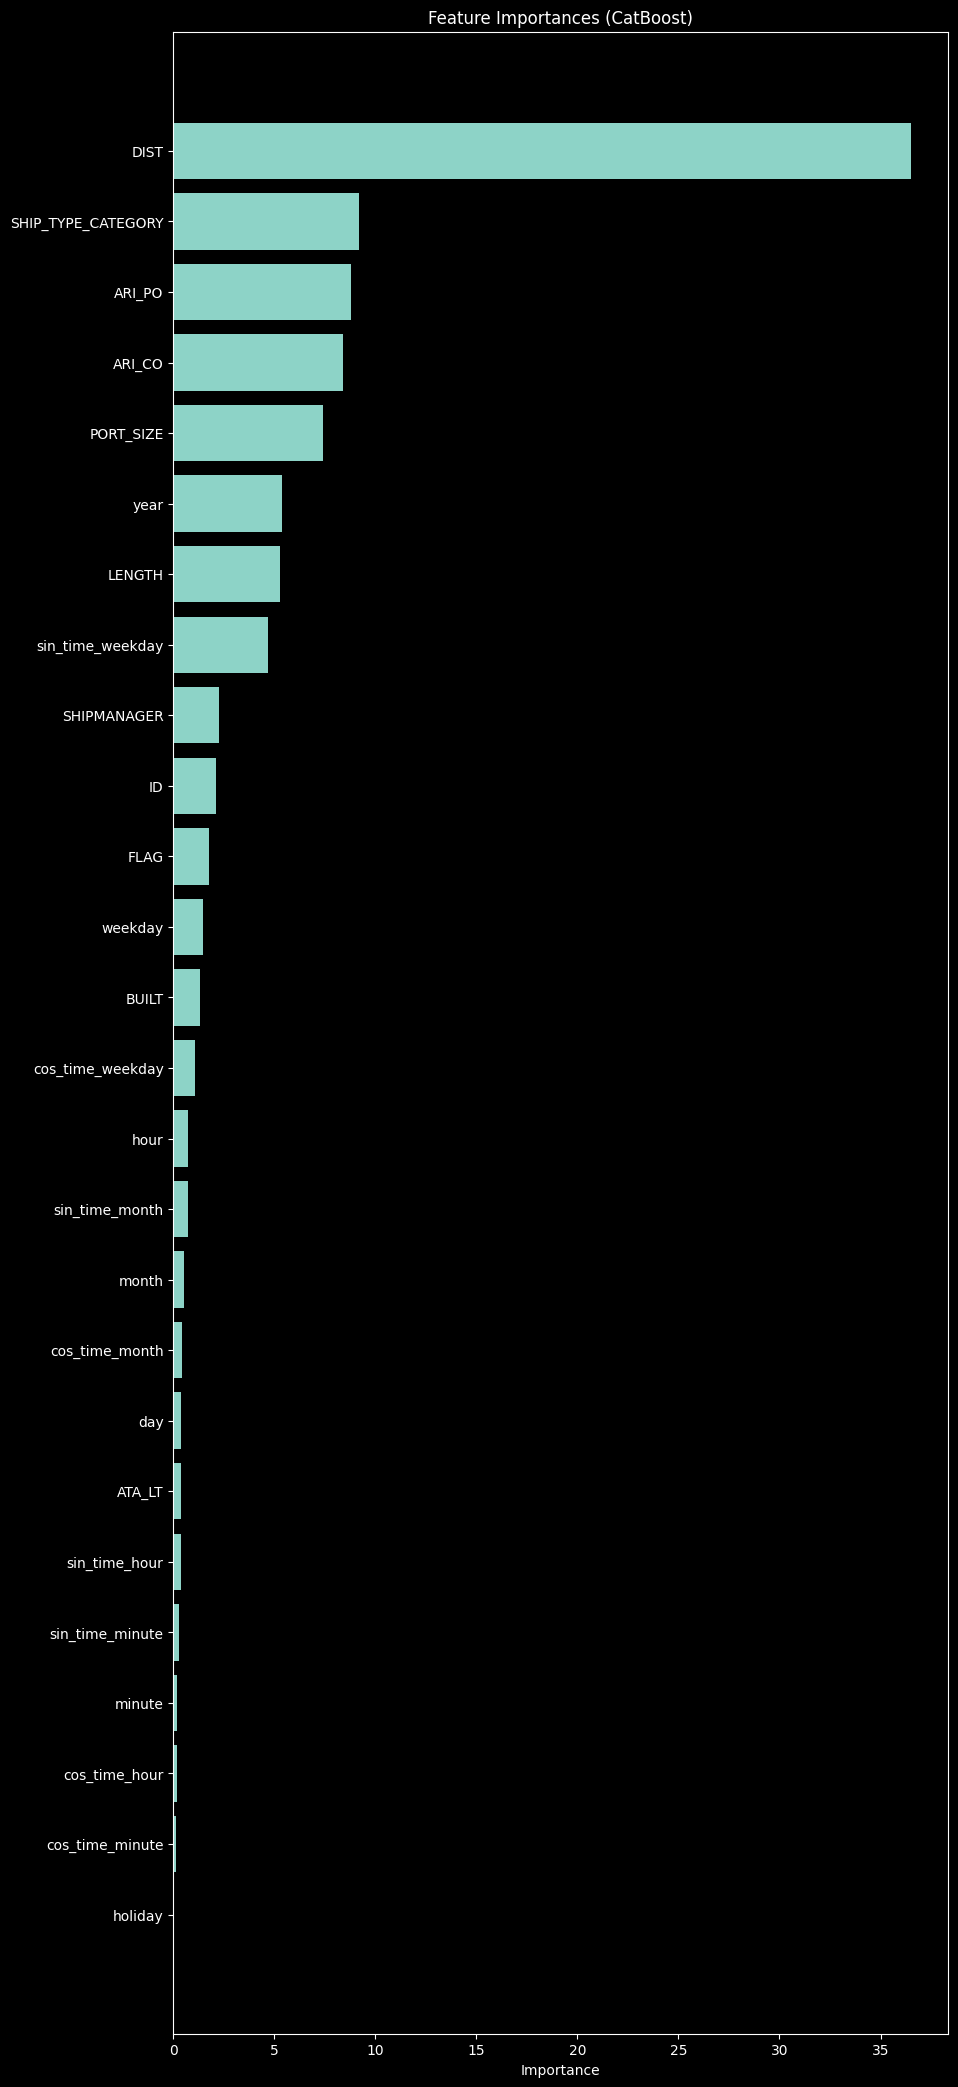

In [5]:
from catboost import CatBoostRegressor

def train_and_evaluate(model, model_name, X_train, y_train, cat_features= ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train, cat_features=cat_features)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

catboost_model = CatBoostRegressor()
catboost_model, catboost_feature_importances = train_and_evaluate(catboost_model, 'CatBoost', X_train, y_train)

In [7]:
# threshold 선정

import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error

# Threshold 후보 리스트 정의
thresholds = [0.5,1,1.5,2,2.5,3]

best_mae = float('inf')
best_threshold = None

cat_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']

for threshold in thresholds:
    low_importance_features = X_train.columns[catboost_feature_importances < threshold]
    X_train_reduced = X_train.drop(columns=low_importance_features)
    X_test_reduced = test.drop(columns=low_importance_features)

    # CatBoost 모델 초기화
    catboost_model = CatBoostRegressor(cat_features=cat_features)


    # 5-Fold 설정
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
    ensemble_predictions = []
    scores = []

    for train_idx, val_idx in kf.split(X_train_reduced):
        X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
        y_t, y_val = y_train[train_idx], y_train[val_idx]

        # CatBoost 모델 학습
        catboost_model.fit(X_t, y_t)

        # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
        val_pred = catboost_model.predict(X_val)

        # Validation set에 대한 대회 평가 산식 계산 후 저장
        scores.append(mean_absolute_error(y_val, val_pred))

        # test 데이터셋에 대한 예측 수행 후 저장
        catboost_pred = catboost_model.predict(X_test_reduced)
        catboost_pred = np.where(catboost_pred < 0, 0, catboost_pred)

        ensemble_predictions.append(catboost_pred)

    # K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
    final_predictions = np.mean(ensemble_predictions, axis=0)

    # 현재 threshold 값과 MAE 출력
    print(f"Threshold: {threshold}, Validation MAE: {np.mean(scores)}")

 # 현재 threshold의 MAE가 더 작으면 최적 threshold 및 MAE 업데이트
    if np.mean(scores) < best_mae:
        best_mae = np.mean(scores)
        best_threshold = threshold

# 최적 threshold 및 MAE 출력

print(f"Best Threshold: {best_threshold}, Best Validation MAE: {best_mae}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
335:	learn: 50.9992956	total: 2m 15s	remaining: 4m 27s
336:	learn: 50.9948898	total: 2m 15s	remaining: 4m 27s
337:	learn: 50.9910333	total: 2m 16s	remaining: 4m 26s
338:	learn: 50.9888158	total: 2m 16s	remaining: 4m 26s
339:	learn: 50.9859616	total: 2m 16s	remaining: 4m 25s
340:	learn: 50.9827423	total: 2m 17s	remaining: 4m 25s
341:	learn: 50.9810925	total: 2m 17s	remaining: 4m 24s
342:	learn: 50.9793063	total: 2m 18s	remaining: 4m 24s
343:	learn: 50.9761557	total: 2m 18s	remaining: 4m 24s
344:	learn: 50.9751626	total: 2m 18s	remaining: 4m 23s
345:	learn: 50.9722715	total: 2m 19s	remaining: 4m 23s
346:	learn: 50.9706138	total: 2m 20s	remaining: 4m 23s
347:	learn: 50.9692016	total: 2m 20s	remaining: 4m 23s
348:	learn: 50.9662912	total: 2m 20s	remaining: 4m 23s
349:	learn: 50.9649123	total: 2m 21s	remaining: 4m 22s
350:	learn: 50.9638349	total: 2m 21s	remaining: 4m 22s
351:	learn: 50.9608436	total: 2m 22s	remaining: 4m 21s
352:	learn: 50.9547212	total:

KeyboardInterrupt: ignored

In [10]:
X_t

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,LENGTH,PORT_SIZE,year,sin_time_weekday
0,SG,GIW5,Container,30.881018,180.0,0.002615,2018,0.000000
1,IN,UJM2,Bulk,0.000000,180.0,0.000217,2014,0.781831
3,JP,ZAG4,Container,0.000000,120.0,0.000356,2020,-0.433884
4,SG,GIW5,Container,27.037650,300.0,0.002615,2020,-0.781831
5,AU,WHH4,Bulk,49.953585,290.0,0.000103,2021,-0.433884
...,...,...,...,...,...,...,...,...
379811,CN,WAF5,Bulk,21.866691,290.0,0.000618,2017,0.433884
379812,JP,QYY1,Container,0.000000,110.0,0.000552,2017,0.781831
379813,SG,GIW5,Bulk,5.884603,80.0,0.002615,2019,0.974928
379814,US,QGN3,Bulk,70.660241,200.0,0.000155,2021,0.781831


In [6]:
# 그리드 서치

import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error

# 가장 성능 좋았던 Threshold 정의
threshold = 2.5

best_mae = float('inf')
best_threshold = None

low_importance_features = X_train.columns[catboost_feature_importances < threshold]
X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)




# GridSearchCV에 사용할 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [0.1],
    'depth': [12],
    'iterations': [200]
}

# CatBoost 모델 초기화
new_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY']
catboost_model = CatBoostRegressor(cat_features=new_features)

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
grid_search = GridSearchCV(catboost_model, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid_search.fit(X_train_reduced, y_train)

# 최적의 하이퍼파라미터와 MAE 출력
best_params = grid_search.best_params_
best_mae = -grid_search.best_score_
print('--- 최적 하이퍼 파라미터 ---')
print("Best Hyperparameters:", best_params)
print("Best Validation MAE:", best_mae)

# 최적의 하이퍼파라미터로 모델 초기화
best_catboost_model = CatBoostRegressor(**best_params)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in kf.split(X_train_reduced):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # CatBoost 모델 학습
    best_catboost_model.fit(X_t, y_t,cat_features=new_features)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = best_catboost_model.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    catboost_pred = best_catboost_model.predict(X_test_reduced)
    catboost_pred = np.where(catboost_pred < 0, 0, catboost_pred)

    ensemble_predictions.append(catboost_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score 출력
print("Validation MAE scores for each fold:", scores)
print("Validation MAE:", np.mean(scores))

0:	learn: 64.7967814	total: 751ms	remaining: 2m 29s
1:	learn: 62.8811142	total: 1.45s	remaining: 2m 23s
2:	learn: 61.2441461	total: 2.63s	remaining: 2m 52s
3:	learn: 59.9120346	total: 3.8s	remaining: 3m 6s
4:	learn: 58.7824688	total: 4.64s	remaining: 3m 1s
5:	learn: 57.8136952	total: 5.25s	remaining: 2m 49s
6:	learn: 57.0236699	total: 5.77s	remaining: 2m 39s
7:	learn: 56.3464961	total: 6.43s	remaining: 2m 34s
8:	learn: 55.7845804	total: 7.1s	remaining: 2m 30s
9:	learn: 55.2990924	total: 7.73s	remaining: 2m 26s
10:	learn: 54.8638576	total: 8.4s	remaining: 2m 24s
11:	learn: 54.5324783	total: 8.95s	remaining: 2m 20s
12:	learn: 54.2152995	total: 9.62s	remaining: 2m 18s
13:	learn: 53.9655651	total: 10.2s	remaining: 2m 15s
14:	learn: 53.7328988	total: 10.8s	remaining: 2m 12s
15:	learn: 53.5494042	total: 11.3s	remaining: 2m 9s
16:	learn: 53.3554638	total: 11.9s	remaining: 2m 7s
17:	learn: 53.1974673	total: 12.6s	remaining: 2m 7s
18:	learn: 53.0494118	total: 13.2s	remaining: 2m 5s
19:	learn: 5

In [7]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./CatBoost_sumbmit_10.20.csv', index=False)

## XGBoost

In [9]:
# 3. Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


Model Tune for XGBoost.


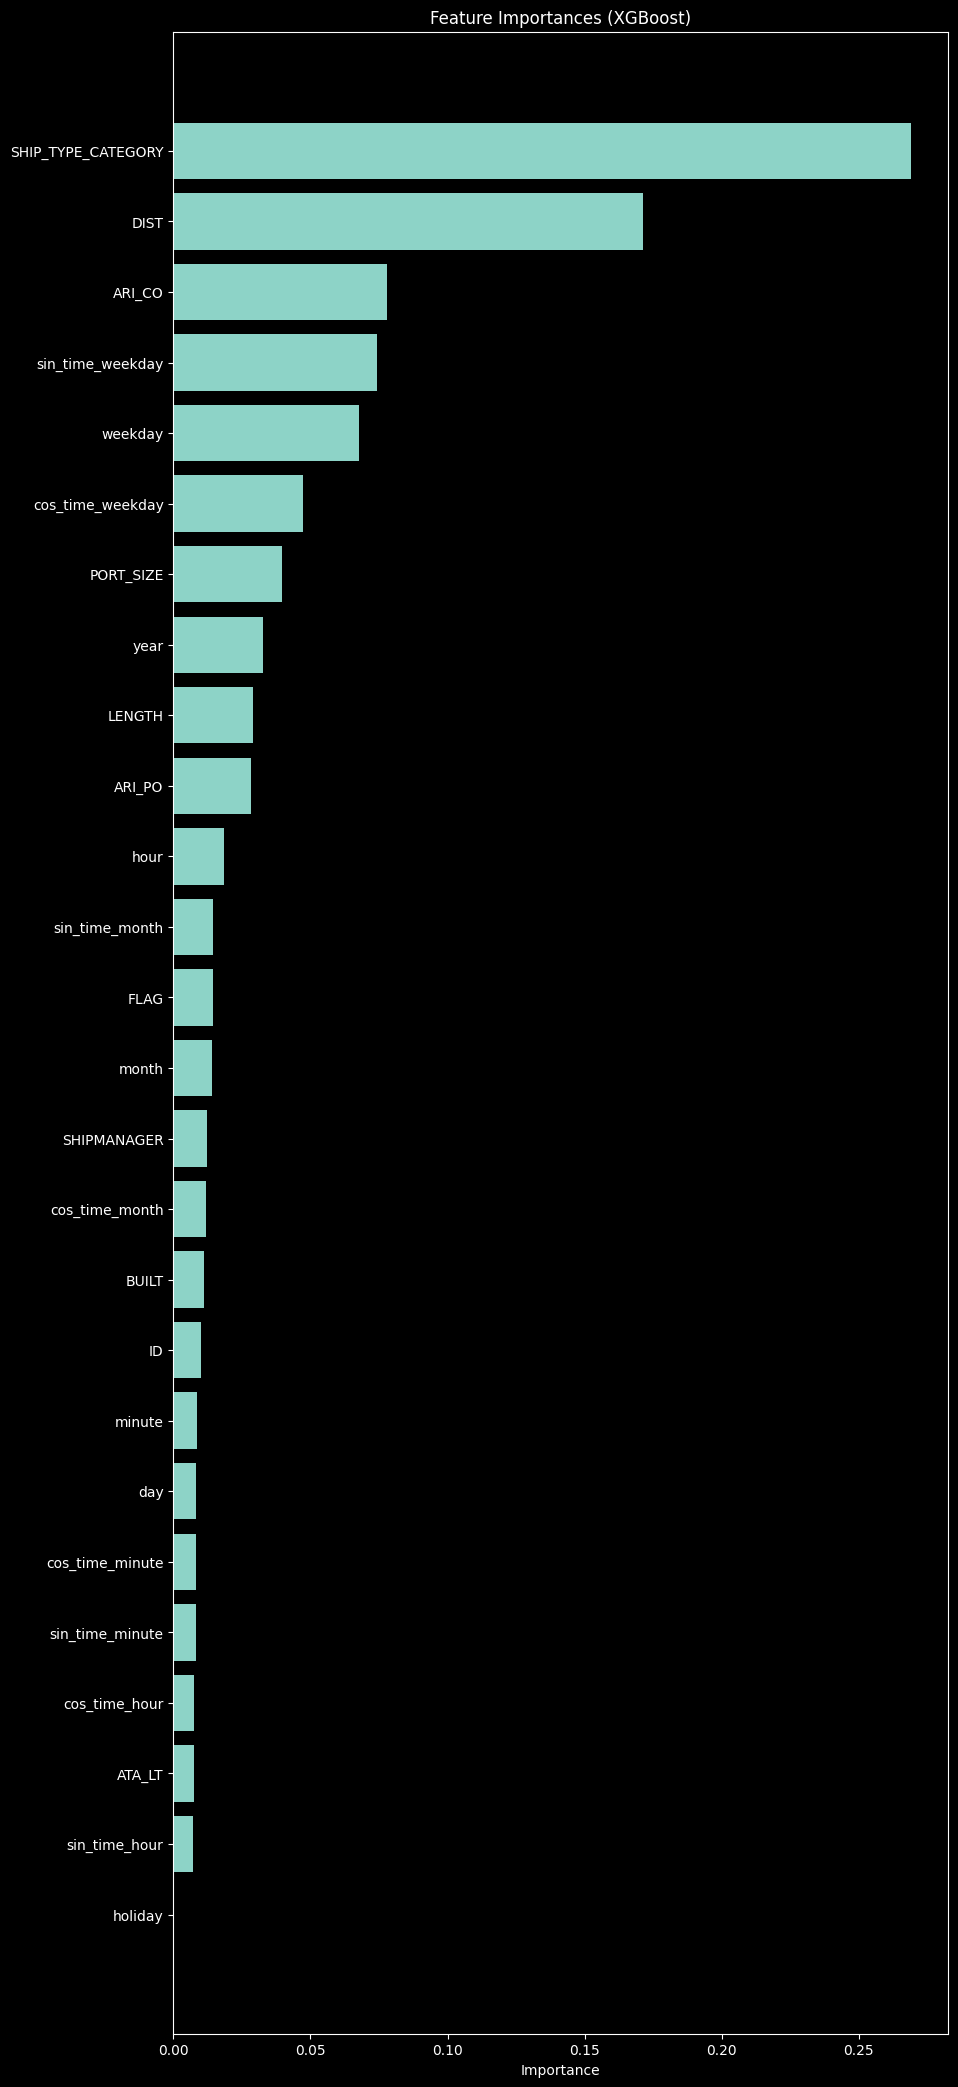

In [10]:
import xgboost as xgb

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']


# Model Tune for XGBoost
xgb_model, xgb_feature_importances = train_and_evaluate(xgb.XGBRegressor(), 'XGBoost', X_train, y_train)

In [11]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# Threshold 후보 리스트 정의
thresholds = [0.02, 0.03, 0.04, 0.045, 0.05, 0.06]  # 원하는 threshold 값들을 리스트에 추가하세요

# MAE와 해당 threshold 값을 저장할 변수 초기화
best_mae = float('inf')
best_threshold = None

for threshold in thresholds:
    # Low importance feature 제거
    low_importance_features = X_train.columns[xgb_feature_importances < threshold]
    X_train_reduced = X_train.drop(columns=low_importance_features)
    X_test_reduced = test.drop(columns=low_importance_features)

    # XGBoost 모델 초기화
    xgb_model = xgb.XGBRegressor()

    # 5-Fold 설정
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
    ensemble_predictions = []
    scores = []

    for train_idx, val_idx in kf.split(X_train_reduced):
        X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
        y_t, y_val = y_train[train_idx], y_train[val_idx]

        # XGBoost 모델 학습
        xgb_model.fit(X_t, y_t)

        # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
        val_pred = xgb_model.predict(X_val)

        # Validation set에 대한 대회 평가 산식 계산 후 저장
        scores.append(mean_absolute_error(y_val, val_pred))

        # test 데이터셋에 대한 예측 수행 후 저장
        xgb_pred = xgb_model.predict(X_test_reduced)
        xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)

        ensemble_predictions.append(xgb_pred)

    # K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
    final_predictions = np.mean(ensemble_predictions, axis=0)

    # 현재 threshold 값과 MAE 출력
    print(f"Threshold: {threshold}, Validation MAE: {np.mean(scores)}")

    # 현재 threshold의 MAE가 더 작으면 최적 threshold 및 MAE 업데이트
    if np.mean(scores) < best_mae:
        best_mae = np.mean(scores)
        best_threshold = threshold

# 최적 threshold 및 MAE 출력
print(f"Best Threshold: {best_threshold}, Best Validation MAE: {best_mae}")


Threshold: 0.02, Validation MAE: 26.485610192433985
Threshold: 0.03, Validation MAE: 26.743204763748146
Threshold: 0.04, Validation MAE: 27.506407444788785
Threshold: 0.045, Validation MAE: 27.506407444788785
Threshold: 0.05, Validation MAE: 27.508349055709505
Threshold: 0.06, Validation MAE: 27.508349055709505
Best Threshold: 0.02, Best Validation MAE: 26.485610192433985


In [12]:
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV  # 필요한 라이브러리 추가
from sklearn.metrics import mean_absolute_error

threshold = 0.03 # Your Threshold
low_importance_features = X_train.columns[xgb_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

low_importance_features

# 그리드 서치를 위한 하이퍼파라미터 그리드 정의하기
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300]
}

# XGBoost 모델 초기화
xgb_model = xgb.XGBRegressor()

# 그리드 서치 객체 생성
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_absolute_error', n_jobs=-1)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

    # 그리드 서치 수행
grid_search.fit(X_train_reduced, y_train)

    # 최적 모델을 얻고 학습 데이터에 대한 예측 수행
best_model = grid_search.best_estimator_
best_model.fit(X_train_reduced, y_train)

print("최적 하이퍼파라미터:", grid_search.best_params_)

최적 하이퍼파라미터: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}


In [13]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

threshold = 0.03

# MAE와 해당 threshold 값을 저장할 변수 초기화
best_mae = float('inf')
best_threshold = None


low_importance_features = X_train.columns[xgb_feature_importances < threshold]
X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

# XGBoost 모델 초기화
xgb_model = xgb.XGBRegressor(learning_rate=0.2, max_depth=5, n_estimators=300)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in kf.split(X_train_reduced):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # XGBoost 모델 학습
    xgb_model.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = xgb_model.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    xgb_pred = xgb_model.predict(X_test_reduced)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)

    ensemble_predictions.append(xgb_pred)

    # K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
    final_predictions = np.mean(ensemble_predictions, axis=0)

    # 현재 threshold 값과 MAE 출력
    print(f"Validation MAE: {np.mean(scores)}")

        # 현재 threshold의 MAE가 더 작으면 최적 threshold 및 MAE 업데이트
    if np.mean(scores) < best_mae:
        best_mae = np.mean(scores)
        best_threshold = threshold

# 최적 threshold 및 MAE 출력
print(f"Best Threshold: {best_threshold}, Best Validation MAE: {best_mae}")

Validation MAE: 26.670430904909228
Validation MAE: 26.74729441825866
Validation MAE: 26.796876708229984
Validation MAE: 26.77831811261278
Validation MAE: 26.81859007755139
Best Threshold: 0.03, Best Validation MAE: 26.670430904909228


In [14]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./XGboost_GridSearch_submit.10_20.csv', index=False)